Alexander S. Lundervold & Arvid Lundervold, 15.09.22

# Using deep learning to extract imaging-biomarkers for brain cancer analyses in MRI of glioma

<img width=40% src="https://upload.wikimedia.org/wikipedia/commons/6/64/Glioblastoma_macro.jpg">

In this notebook, we'll use a deep learning model to segment brain tumors from multi-parametric MRI and then extract features from the resulting tumor masks. Such features can potentially be associated with tumor severity and prognosis and contribute to better treatment. 

Extracting features from objects of interest in medical images for diagnostic purposes is often referred to as **radiomics**. The goal of radiomics is to extract information from medical images that can be used as part of a medical imaging-based diagnostic workflow. The information can be extracted from various imaging modalities, e.g., different MRI contrasts, PET imaging, CT imaging, and so on. One can then combine it with other sources of information (e.g., demographics, clinical data, genetics). In such a way, radiomics–and **radiogenomics**–can open the door to sophisticated and powerful analyses. 

## Radiomics workflow

In this notebook, we will estimate the locations and extent of the brain tumors' T2-enhancing and non-enhancing regions. We can then use this to extract the tumor location and the tumor burden. Additionally, we can look at the features of the MRI images inside each of these two tumor parts. 

<img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/radiomics.png">

## Tumor segmentation provides tumor volumes and locations

Tumor burden and anatomical locations are highly informative when assessing prognosis and planning treatment in brain tumors. Once we can segment the tumors, we automatically obtain tumor volumes. If we have repeated scans of the same tumors, we obtain estimates of tumor progression. By further analyses one can also estimate the anatomical locations of the tumors. 

### Tumor segmentation

<img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/tumor_segmentation.png">

### Tumor progression

<img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/tumor_volumes.png">

### Tumor localization

Using software that can segment the brain into meaningful anatomical regions (for example, FreeSurfer), one can estimate the overlap between the tumor and these anatomical regions. This provides **tumor localization**, which is of course highly relevant for assessment and prognosis. 

<img src="https://upload.wikimedia.org/wikipedia/commons/9/9e/Brainanim.gif">
<center><small> Freesurfer parcellation and segmentation</small></center>

<img width=60% src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/tumor_locations.png">

## Data from TCGA

We'll use data from the TCGA collection:

<img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets//tcga.png">

## Download and extract some sample data:

In [1]:
%pip install gdown

  Using cached gdown-4.6.4-py3-none-any.whl (14 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 625.2 kB/s eta 0:00:00a 0:00:01
  Using cached filelock-3.9.0-py3-none-any.whl (9.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gdown
from pathlib import Path
import shutil

In [3]:
Path("data").mkdir(exist_ok=True)

In [5]:
url = "https://drive.google.com/uc?id=1qUQ_ICf0zVKxBW8NtLmLPGAZtZZ6vI6K"
output = "data/tcga-data.zip"

In [6]:
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1qUQ_ICf0zVKxBW8NtLmLPGAZtZZ6vI6K
To: /home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/PRESIMAL-DL-2022/notebooks/data/tcga-data.zip
100%|██████████| 80.8M/80.8M [00:19<00:00, 4.23MB/s]


'data/tcga-data.zip'

In [8]:
shutil.unpack_archive("data/tcga-data.zip", "data")

# Setup

As always, we need to import some libraries and decide where to fetch and store data.

In [9]:
%matplotlib inline

In [10]:
%pip install hd_glio
%pip install seaborn
%pip install ipywidgets

In [11]:
import os, sys, pandas as pd, numpy as np, random, seaborn as sns
import matplotlib.pyplot as plt


import nibabel as nib

In [12]:
pd.set_option('display.max_columns', 100)

In [13]:
NB_DIR = Path.cwd()
LOCAL_DATA = NB_DIR/'data'
IMG_DATA = LOCAL_DATA/'TCGA'

# Brain tumor imaging data

We will use a small sample data set from the TCGA collection. For simplicity, we use versions of the MRI images that have already been co-registered and converted to NIfTI format: https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=24282668. This saves us a few steps.

We've prepared a small sample data set containing data from 10 subjects.

> **Note:** The TCGA-GBM collection has data from 262 subjects. We use a small sample for illustration.

In [14]:
sample_df = pd.read_csv(LOCAL_DATA/'TCGA-sample_data.csv')

In [15]:
sample_df

,SUBJECT ID,Age,Gender,Histology,Grade,IDH-status,IDH-allele,1p/19q-co-deletion,Survival(months),Karnofsky-score,img_dir
0,TCGA-06-0145,53.0,female,glioblastoma,G4,WT,NaN,non-codel,2.3327,NaN,TCGA-06-0145
1,TCGA-06-0190,62.0,male,glioblastoma,G4,WT,NaN,non-codel,10.4150,80.0,TCGA-06-0190
2,TCGA-06-0646,60.0,male,glioblastoma,G4,WT,NaN,non-codel,5.7496,80.0,TCGA-06-0646
3,TCGA-06-5408,54.0,female,glioblastoma,G4,WT,NaN,non-codel,11.7292,80.0,TCGA-06-5408
4,TCGA-06-5413,67.0,male,glioblastoma,G4,WT,NaN,non-codel,8.8051,60.0,TCGA-06-5413
5,TCGA-06-6389,49.0,female,glioblastoma,G4,Mutant,IDH1,non-codel,7.7866,100.0,TCGA-06-6389
6,TCGA-14-1456,23.0,male,glioblastoma,G4,Mutant,IDH1,non-codel,40.9372,80.0,TCGA-14-1456
7,TCGA-14-3477,38.0,female,glioblastoma,G4,WT,NaN,non-codel,3.7783,80.0,TCGA-14-3477
8,TCGA-19-5954,72.0,female,glioblastoma,G4,WT,NaN,non-codel,7.9509,60.0,TCGA-19-5954
9,TCGA-76-6656,66.0,male,glioblastoma,G4,WT,NaN,non-codel,4.8297,60.0,TCGA-76-6656


For convenience, the corresponding images have already been downloaded:

In [16]:
sorted(list((IMG_DATA/sample_df['img_dir'].values[0]).iterdir()))

[PosixPath('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/PRESIMAL-DL-2022/notebooks/data/TCGA/TCGA-06-0145/TCGA-06-0145_2000.11.06_flair.nii.gz'),
 PosixPath('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/PRESIMAL-DL-2022/notebooks/data/TCGA/TCGA-06-0145/TCGA-06-0145_2000.11.06_t1.nii.gz'),
 PosixPath('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/PRESIMAL-DL-2022/notebooks/data/TCGA/TCGA-06-0145/TCGA-06-0145_2000.11.06_t1Gd.nii.gz'),
 PosixPath('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/PRESIMAL-DL-2022/notebooks/data/TCGA/TCGA-06-0145/TCGA-06-0145_2000.11.06_t2.nii.gz'),
 PosixPath('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/PRESIMAL-DL-2022/notebooks/data/TCGA/TCGA-06-0145/seg')]

Here are all the subject IDs in our sample data set:

In [17]:
subject_ids = sample_df['img_dir'].values
subject_ids

array(['TCGA-06-0145', 'TCGA-06-0190', 'TCGA-06-0646', 'TCGA-06-5408',
       'TCGA-06-5413', 'TCGA-06-6389', 'TCGA-14-1456', 'TCGA-14-3477',
       'TCGA-19-5954', 'TCGA-76-6656'], dtype=object)

## Inspect some images

It's very important to inspect your data. After fetching the data and after performing any transformations on the data. In the case of images, that typically means displaying the images:

In [18]:
def plot_image(subj_id, slice_nb):
    images = [nib.load(i) for i in sorted(list((IMG_DATA/subj_id).glob("*.nii*")))]
    nb_slices = images[0].shape[-1]
    
    flair, t1, t1c, t2 = [np.flip(np.rot90(i.get_fdata()[:,:,slice_nb])) for i in images]

    f,axs = plt.subplots(1,4, figsize=(18,5))
    axs[0].imshow(flair, cmap="gray")
    axs[0].axis('off')
    axs[1].imshow(t1, cmap='gray')
    axs[1].axis('off')
    axs[2].imshow(t1c, cmap="gray")
    axs[2].axis("off")
    axs[3].imshow(t2, cmap="gray")
    axs[3].axis("off")

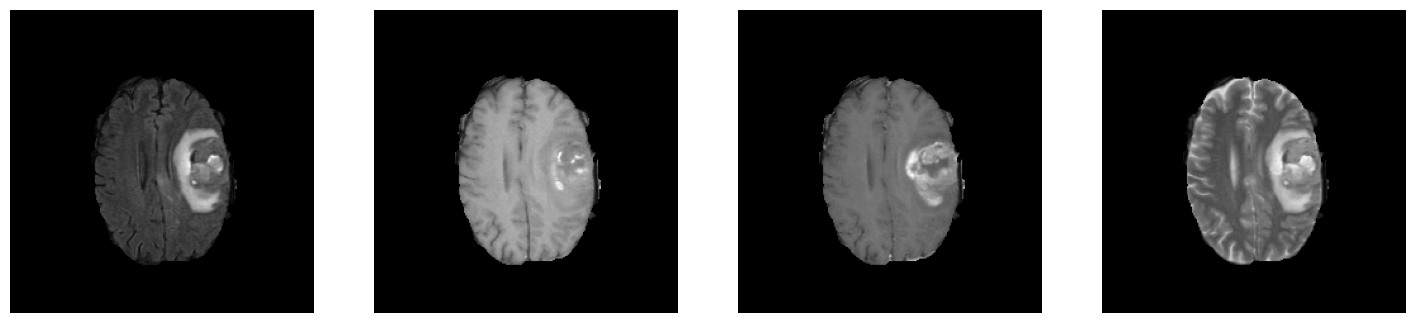

In [19]:
plot_image(subject_ids[0], slice_nb=100)

Understanding the data is such a crucial part of any machine learning project that it's worthwhile to spend a lot of time figuring out ways to construct functions to plot and to inspect features of the data. By using IPyWidgets, we can make our plots interactive:

In [20]:
from ipywidgets import interactive, IntSlider, Select

In [21]:
select_layer = IntSlider(value=100, min=0, max=154, 
                         description='Slice', continuous_update=False)

select_subj = Select(options=subject_ids, description="Subject")

In [22]:
interactive(plot_image, subj_id=select_subj, slice_nb=select_layer)

interactive(children=(Select(description='Subject', options=('TCGA-06-0145', 'TCGA-06-0190', 'TCGA-06-0646', '…

We should also attempt to understand the _distribution_ of the downloaded data in various ways. We can for example ask what  the variation in mean voxel intensities is for each of the image sequences (whole-brain intensities).

In [23]:
intensities = {}
for subj_id in subject_ids:
    flair, t1, t1c, t2 = [np.mean(nib.load(i).get_fdata()) for i in sorted(list((IMG_DATA/subj_id).glob("*.nii*")))]
    intensities[subj_id] = [flair, t1, t1c, t2]

In [24]:
df_intensities = pd.DataFrame.from_dict(intensities, orient='index', 
                                       columns = ['flair', 't1', 't1c', 't2'])

In [25]:
df_intensities

,flair,t1,t1c,t2
TCGA-06-0145,15.592199,34.489715,37.917576,44.270152
TCGA-06-0190,25.485854,46.296293,50.513481,57.134856
TCGA-06-0646,39.505776,77.770795,89.003278,91.876778
TCGA-06-5408,28.564800,49.455247,53.418037,62.991788
TCGA-06-5413,51.155407,78.149601,107.871139,119.434830
TCGA-06-6389,49.575452,71.530700,89.746512,137.181183
TCGA-14-1456,24.673250,42.779937,46.009659,82.604169
TCGA-14-3477,53.518731,48.101099,54.656742,72.503977
TCGA-19-5954,47.905887,40.451770,45.331130,95.440951
TCGA-76-6656,97.105232,77.719332,86.992573,127.178461


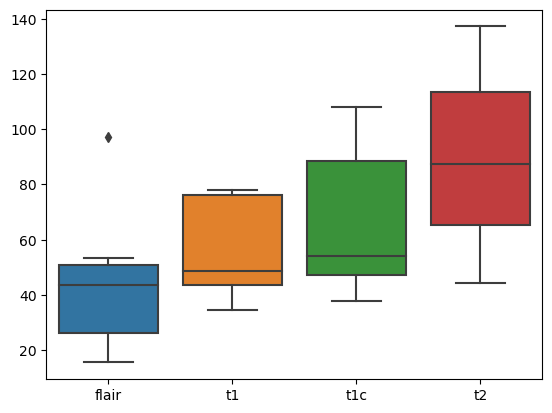

In [26]:
sns.boxplot(data=df_intensities)
plt.show()

We observe quite some variation in the mean voxel intensities across the data set. This leads to a need for some kind of normalization.

# Brain tumor segmentation using HD-GLIO

In this case, we will use an existing model that has already been trained on a large collection of MRI examinations (3220 examinations from 1450 brain tumor patients, sourced from multiple centers). The pipeline, including the trained model and various preprocessing steps, is freely available via the code-sharing platform **GitHub** under an **open source license** (Apache-2.0): https://github.com/NeuroAI-HD/HD-GLIO. 

<img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/open-source.png">

HD-GLIO was constructed as a collaboration between the Department of Neuroradiology at the Heidelberg University Hospital, Germany and the Division of Medical Image Computing at the German Cancer Research Center (DKFZ) Heidelberg, Germany.

## The network architecture: U-Net and the nnU-Net

HD-GLIO is based on a version of the widely used U-Net architecture (also used in our previous notebook). Specifically, it is based on a variant of the open source nnU-Net ("no-new-Net"), available here: https://github.com/MIC-DKFZ/nnUNet. 

**U-Net**

<img src="https://miro.medium.com/max/1400/1*x0kR2rGlTibVbu8InCNBVg.jpeg">

**nnUNet**

The main point of nnUNet is that there is a lot of performance gains to be had by optimizing the deep learning workflow--preprocessing, postprocessing, etc, rather than creating completely new artificial neural network architectures. You can read all about the ideas here: https://www.nature.com/articles/s41592-020-01008-z.

![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41592-020-01008-z/MediaObjects/41592_2020_1008_Fig2_HTML.png)

## Running HD-GLIO on our data

We create a small helper function to run HD-GLIO

In [19]:
def run_hdglio(t1, t1c, t2, flair, output, verbose=True):
    
    if verbose: 
        !CUDA_VISIBLE_DEVICES=0 $sys.exec_prefix/bin/hd_glio_predict -t1 $t1 -t1c $t1c -t2 $t2 -flair $flair -o $output
    if not verbose:
        !CUDA_VISIBLE_DEVICES=0 $sys.exec_prefix/bin/hd_glio_predict -t1 $t1 -t1c $t1c -t2 $t2 -flair $flair -o $output > /dev/null
    
    return output

...and run the already trained model on all our subjects:

In [20]:
%%time
verbose=True

i=1
for subj in subject_ids:
    
    # Specify the file name for the output segmentation
    output_file = LOCAL_DATA/"TCGA"/subj/"seg"/f"{subj.split('/')[-1]}_seg.nii.gz"
    
    # Grab the file names for the four images (T1, T1c, T2, FLAIR)
    flair, t1, t1c, t2 = sorted(list((IMG_DATA/subj).glob("*.nii*")))
    
    # Run HDGLIO (note that it is possible to run HD-GLIO in batch mode, avoiding 
    # having to load the model every time. See the HD-GLIO docs for more)
    print(f"Processing subject #{i}/{len(subject_ids)}: {subj.split('/')[-1]}")
    
    run_hdglio(t1, t1c, t2, flair, output_file, verbose)
    
    print("-"*40)
    print(f"DONE. Output available at {output_file}")
    print()
    print("#"*40)
    print("#"*40)
    
    i+=1

Processing subject #1/10: TCGA-06-0145

########################
If you are using hd-bet, please cite the following papers:

Kickingereder P, Isensee F, Tursunova I, Petersen J, Neuberger U, Bonekamp D, Brugnara G, Schell M, Kessler T, Foltyn M, Harting I, Sahm F, Prager M, Nowosielski M, Wick A, Nolden M, Radbruch A, Debus J, Schlemmer HP, Heiland S, Platten M, von Deimling A, van den Bent MJ, Gorlia T, Wick W, Bendszus M, Maier-Hein KH. Automated quantitative tumour response assessment of MRI in neuro-oncology with artificial neural networks: a multicentre, retrospective study. Lancet Oncol. 2019 May;20(5):728-740. https://doi.org/10.1016/S1470-2045(19)30098-1

Isensee, Fabian, et al. "nnU-Net: Breaking the Spell on Successful Medical Image Segmentation." arXiv preprint arXiv:1904.08128 (2019). (https://arxiv.org/abs/1904.08128)

emptying cuda cache
loading parameters for folds, (0,)
using the following model files:  ['/home/ubuntu/hd_glio_params/fold_0/model_final_checkpoint.model']

using the following model files:  ['/home/ubuntu/hd_glio_params/fold_0/model_final_checkpoint.model']
starting preprocessing generator
starting prediction...
preprocessing /home/ubuntu/Dropbox/medGPU-alex/PRESIMAL-DL-2022/notebooks/data/TCGA/TCGA-06-5408/seg/TCGA-06-5408_seg.nii.gz
using preprocessor GenericPreprocessor
before crop: (4, 155, 240, 240) after crop: (4, 134, 166, 141) spacing: [1. 1. 1.] 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 134, 166, 141)} 
after:  {'spacing': array([1, 1, 1]), 'data.shape (data is resampled)': (4, 134, 166, 141)} 

(4, 134, 166, 141)
This worker has ended successfully, no errors to report
predicting /home/ubuntu/Dropbox/medGPU-alex/PRESIMAL-DL-2022/notebooks/data/TCGA/TCGA-06-5408/seg/TCGA-06-5408_seg.nii.gz
debug: mirroring True mirror_axes (0, 1, 2)
step_size: 0.5
do mirror: True
data shape: (4, 134, 166, 141)
patch si

prediction done
inference done. Now waiting for the segmentation export to finish...
force_separate_z: None interpolation order: 1
no resampling necessary
postprocessing...
----------------------------------------
DONE. Output available at /home/ubuntu/Dropbox/medGPU-alex/PRESIMAL-DL-2022/notebooks/data/TCGA/TCGA-14-1456/seg/TCGA-14-1456_seg.nii.gz

########################################
########################################
Processing subject #8/10: TCGA-14-3477

########################
If you are using hd-bet, please cite the following papers:

Kickingereder P, Isensee F, Tursunova I, Petersen J, Neuberger U, Bonekamp D, Brugnara G, Schell M, Kessler T, Foltyn M, Harting I, Sahm F, Prager M, Nowosielski M, Wick A, Nolden M, Radbruch A, Debus J, Schlemmer HP, Heiland S, Platten M, von Deimling A, van den Bent MJ, Gorlia T, Wick W, Bendszus M, Maier-Hein KH. Automated quantitative tumour response assessment of MRI in neuro-oncology with artificial neural networks: a multicentre, 

## Inspect results

We've now produced segmentation masks for our tumor images. Here's a a small widget to plot the resulting segmentation masks and the corresponding T2 images.

In [21]:
from ipywidgets import ToggleButtons, fixed

In [22]:
classes_dict = {
    'Normal': 0.,
    'Contrast-enhancing': 1.,
    'Non-enhancing': 2.,
}

channel_dict = {
    'Flair': 0.,
    'T1': 1.,
    'T1c': 2.,
    'T2': 3
}

In [23]:
# Plotting function
def plot_segmentation(subj_id, channel, seg_class, slice_nb):
    
    flair, t1, t1c, t2 = [nib.load(i) for i in sorted(list((IMG_DATA/subj_id).glob("*.nii*")))]
    mri_channels = {'Flair': flair, 'T1': t1, 'T1c': t1c, 'T2': t2}
    
    mask = nib.load(list((IMG_DATA/subj_id/"seg").glob("*.nii*"))[0])
    
    nb_slices = mri_channels[channel].shape[-1]
    
    img_data = np.flip(np.rot90(mri_channels[channel].get_fdata()[:,:,slice_nb]))
    mask_data = np.flip(np.rot90(mask.get_fdata()[:,:,slice_nb]))
    
    print(f"Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(mask_data == img_label, 255, 0)
    
    f,axs = plt.subplots(1,3, figsize=(18,5))
    axs[0].imshow(img_data, cmap="gray")
    axs[0].axis('off')
    axs[1].imshow(mask, cmap='binary')
    axs[1].axis('off')
    axs[2].imshow(mask, cmap="Blues")
    axs[2].imshow(img_data, cmap="gray", alpha=0.7)
    axs[2].axis("off")

Set up the interactive elements of our widget:

In [24]:
# Button
select_class = ToggleButtons(
    options=['Contrast-enhancing', 'Non-enhancing'],
    description='Select Label:',
    button_style='info', 
    
)
select_channel = ToggleButtons(
    options=list(channel_dict.keys()),
    description='Select Channel:',
    button_style='info', 
    
)

# Slice slider
select_layer = IntSlider(value=100, min=0, max=254, 
                         description='Slice', continuous_update=False)

# Subject selector
select_subj = Select(options=subject_ids, description="Subject")

In [25]:
interactive(plot_segmentation, channel=select_channel, subj_id=select_subj,
            seg_class=select_class, slice_nb=select_layer)

interactive(children=(Select(description='Subject', options=('TCGA-06-0145', 'TCGA-06-0190', 'TCGA-06-0646', '…

# Radiomics: extracting tumor features

<img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/radiomics.png">

Volume and location information for tumors is important, but there's a lot more information represented in the images. Information that could be useful for more precise diagnosis and prognosis. For example, the shape of the tumors, the tumors appearance in the different MRI contrast images, the heterogeneity in the various compartments of the tumors, and so on. As mentioned, such ideas leads us to **radiomics**.

There is a vast number of possible features to extract (at least several hundreds, depending on the number of imaging modalities), related to shape, intensity values and variation, and texture features from each of the MRI modalities. The robustness and relevance of the various features is somewhat unclear, but there's a lot of research into the clinical relevance of radiomics.

For demonstration purposes, we extract only the total volumes, a few shape features, and some texture information. More precisely, we extract:

1. The size of the enhancing and non-enhancing tumor
2. The maximum 3D diameter
3. Mean and variance of the intensities in the T1, T1c, T2, FLAIR in the enhancing and non-enhancing areas
4. The gray level nonuniformity in T1, T1c, T2, FLAIR.

### Data-driven science

> **Note:** It is interesting to contrast _data-driven_ and biologically and clinically inspired analyses. In principle, one can use and discover complicated features that are linked to important outcomes (e.g., survival) _driectly from the data_. Features that are potentially not understood from a biological point of view. This can, of course, also be quite dangerous, as one may uncover _spurious, meaningless patterns_ in the data one has collected. There will also be issues with _explainability_ if one drops the link to biological explanations. 

### RANO criteria for Glioblastoma Multiforme

<img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/rano.png">

## Extracting features using PyRadiomics

To extract radiomic features, we use an established, open-source library developed by the imaging community, PyRadiomics. The library aims to be the reference standard for radiomic analysis, easing both analyses and enabling greater reproducibility. PyRadiomics is available on GitHub: https://github.com/AIM-Harvard/pyradiomics.

<img src="https://www.radiomics.io/img/pyrad1.jpg">

<img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/pyradiomics.png">

We specify the features we'd like to extract in a file (YAML format):

In [26]:
%cat pyradiomics_settings.yaml

# #############################  Extracted using PyRadiomics version: 3.0.1  ######################################

imageType:
  Original: {}

featureClass:
  # redundant Compactness 1, Compactness 2 an Spherical Disproportion features are disabled by default, they can be
  # enabled by specifying individual feature names (as is done for glcm) and including them in the list.
  shape:
    - 'Maximum3DDiameter'
    - 'MeshVolume'
  firstorder:
    - 'Mean'
    - 'Variance'
  gldm:
    - 'GrayLevelNonUniformity'

setting:
  # Normalization:
  # MR signal is usually relative, with large differences between scanners and vendors. By normalizing the image before
  # feature calculation, this confounding effect may be reduced. However, if only one specific scanner is used, or the
  # images reflect some absolute world value (e.g. ADC maps, T2maps (NOT T2 weighted)), consider disabling the
  # normalization.
  normalize: true
  normalizeScale: 100  # This allows you to use more or less the sam

In [ ]:
#%pip install pyradiomics # Note: max Python v3.7

In [27]:
from radiomics import featureextractor

In [28]:
def get_radiomics(images, mask, params='pyradiomics_settings.yaml'):
    results = {}
    
    subject_id = images[0].stem.split("_")[0]
    results['SUBJECT ID'] = subject_id
    
    # Some features are the same across all individual MRI image sequences 
    # We can extract them from any sequence

    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.loadParams(params)
    
    
    result_label1 = extractor.execute(str(images[0]), mask, label=1)
    result_label2 = extractor.execute(str(images[0]), mask, label=2)
        
    results[f'Volume_label1'] = result_label1['original_shape_MeshVolume'].round(2)
    results[f'Volume_label2'] = result_label2['original_shape_MeshVolume'].round(2)
        
    results[f'Max3DDiameter_label1'] = result_label1['original_shape_Maximum3DDiameter'].round(2)
    results[f'Max3DDiameter_label2'] = result_label2['original_shape_Maximum3DDiameter'].round(2)
    
    
    
    # Other features we extract from each individual type of MRI image

    for img in images:
        img_type = img.stem.split("_")[-1].split(".")[0]
        result_label1 = extractor.execute(str(img), mask, label=1)
        result_label2 = extractor.execute(str(img), mask, label=2)
        
        
        # Mean intensity
        
        results[f'{img_type}_MeanIntensity_label1'] = result_label1['original_firstorder_Mean'].round(2)
        results[f'{img_type}_MeanIntensity_label2'] = result_label2['original_firstorder_Mean'].round(2)
        
        # Intensity variance
        
        results[f'{img_type}_IntensityVariance_label1'] = result_label1['original_firstorder_Variance'].round(2)
        results[f'{img_type}_IntensityVariance_label2'] = result_label2['original_firstorder_Variance'].round(2)
        
        # Gray level nonuniformity
        
        results[f'{img_type}_GrayLevelNonUniformity_label1'] = result_label1['original_gldm_GrayLevelNonUniformity'].round(2)
        results[f'{img_type}_GrayLevelNonUniformity_label2'] = result_label2['original_gldm_GrayLevelNonUniformity'].round(2)       
        
        
    results = pd.DataFrame.from_dict(results, orient='index').T
    
    return results

## Run extraction on all subjects

In [29]:
results = []
i=1
for subject_id in subject_ids:
    print(f"#{i}: Computing radiomic features for subject {subject_id}")
    images = sorted(list((LOCAL_DATA/'TCGA'/subject_id).glob('*.nii.gz')))
    mask = str(list((LOCAL_DATA/'TCGA'/subject_id/'seg').glob('*.nii.gz'))[0])
    res = get_radiomics(images, mask)
    results.append(res)
    i+=1

#1: Computing radiomic features for subject TCGA-06-0145
#2: Computing radiomic features for subject TCGA-06-0190
#3: Computing radiomic features for subject TCGA-06-0646
#4: Computing radiomic features for subject TCGA-06-5408
#5: Computing radiomic features for subject TCGA-06-5413
#6: Computing radiomic features for subject TCGA-06-6389
#7: Computing radiomic features for subject TCGA-14-1456
#8: Computing radiomic features for subject TCGA-14-3477
#9: Computing radiomic features for subject TCGA-19-5954
#10: Computing radiomic features for subject TCGA-76-6656


We construct a data frame that stores the resulting radiomic features:

In [30]:
radiomic_df = pd.concat(results)

In [31]:
radiomic_df

,SUBJECT ID,Volume_label1,Volume_label2,Max3DDiameter_label1,Max3DDiameter_label2,flair_MeanIntensity_label1,flair_MeanIntensity_label2,flair_IntensityVariance_label1,flair_IntensityVariance_label2,flair_GrayLevelNonUniformity_label1,flair_GrayLevelNonUniformity_label2,t1_MeanIntensity_label1,t1_MeanIntensity_label2,t1_IntensityVariance_label1,t1_IntensityVariance_label2,t1_GrayLevelNonUniformity_label1,t1_GrayLevelNonUniformity_label2,t1Gd_MeanIntensity_label1,t1Gd_MeanIntensity_label2,t1Gd_IntensityVariance_label1,t1Gd_IntensityVariance_label2,t1Gd_GrayLevelNonUniformity_label1,t1Gd_GrayLevelNonUniformity_label2,t2_MeanIntensity_label1,t2_MeanIntensity_label2,t2_IntensityVariance_label1,t2_IntensityVariance_label2,t2_GrayLevelNonUniformity_label1,t2_GrayLevelNonUniformity_label2
0,TCGA-06-0145,30701.67,26001.33,72.69,56.6,545.89,520.27,17906.53,38098.04,44.54,35.22,272.29,300.89,760.96,2055.93,218.97,124.33,263.96,403.47,1252.29,6356.06,195.9,68.01,369.16,374.67,4666.61,8987.5,81.17,61.59
0,TCGA-06-0190,128178.67,25481.33,103.42,54.99,448.48,414.06,8184.0,5077.55,306.96,64.89,219.34,231.09,525.28,313.06,987.6,264.56,202.12,446.16,942.42,11401.6,809.47,41.91,315.7,345.5,3926.52,3926.48,370.78,79.03
0,TCGA-06-0646,15071.0,4880.33,65.05,44.09,368.24,315.77,1062.94,2117.91,92.98,32.98,217.28,163.6,2668.47,761.87,53.54,41.08,200.47,563.07,4860.44,20406.87,44.82,8.08,290.63,306.04,2745.87,1011.14,53.24,42.82
0,TCGA-06-5408,121208.0,50953.0,99.32,83.09,429.72,377.25,7213.6,7954.84,252.65,101.61,241.72,257.0,732.93,690.8,833.99,375.77,228.83,404.01,1056.91,6694.63,702.04,109.29,322.21,347.75,3648.17,3265.1,367.37,158.97
0,TCGA-06-5413,33458.67,20032.67,77.43,48.58,328.59,257.49,844.75,1505.89,215.12,101.25,190.81,177.51,1941.83,1684.3,138.2,90.71,171.68,351.86,2121.75,11083.82,134.3,37.81,263.81,241.59,1824.67,1936.27,138.97,89.8
0,TCGA-06-6389,25354.33,22306.0,69.08,76.58,346.28,292.98,1138.59,1413.05,138.17,127.64,200.65,144.93,1874.83,1857.54,106.84,103.79,198.6,367.52,2450.45,8321.2,100.32,43.24,245.79,255.78,1399.23,1615.57,124.78,111.48
0,TCGA-14-1456,71234.0,9018.67,77.56,49.84,357.77,417.64,1926.22,1846.13,290.11,43.82,159.77,186.52,1073.87,797.91,442.08,61.78,172.25,261.03,1135.76,1329.63,410.27,47.19,371.85,361.03,7104.42,4443.53,202.52,30.37
0,TCGA-14-3477,111216.33,17771.0,91.32,57.31,386.45,391.52,2507.88,2298.95,388.33,71.04,249.66,279.76,1491.85,1173.92,498.58,93.96,212.63,353.23,1804.63,3391.7,466.75,53.29,388.8,399.23,9511.52,4840.02,201.82,60.37
0,TCGA-19-5954,117207.67,13970.33,111.61,64.62,374.56,333.61,2546.2,6701.7,428.01,42.3,227.96,220.0,1077.27,1979.18,652.71,76.28,208.37,385.49,1194.29,14661.05,633.9,24.3,295.79,272.45,4088.91,6104.73,321.09,37.48
0,TCGA-76-6656,84425.0,51710.0,101.03,68.64,372.97,308.6,2352.68,1341.83,313.03,289.2,248.07,252.06,382.22,441.93,799.78,453.17,220.71,367.79,763.65,6657.72,661.47,132.09,298.11,297.59,3025.71,2979.46,278.03,193.44


In [32]:
radiomic_df['tumor_volume'] = radiomic_df['Volume_label1'] + radiomic_df['Volume_label2']

## Construct our final data set

Now we can append these features to the other information we have about each subject in the data set: 

In [33]:
sample_df.head()

,SUBJECT ID,Age,Gender,Histology,Grade,IDH-status,IDH-allele,1p/19q-co-deletion,Survival(months),Karnofsky-score,img_dir
0,TCGA-06-0145,53.0,female,glioblastoma,G4,WT,NaN,non-codel,2.3327,NaN,TCGA-06-0145
1,TCGA-06-0190,62.0,male,glioblastoma,G4,WT,NaN,non-codel,10.4150,80.0,TCGA-06-0190
2,TCGA-06-0646,60.0,male,glioblastoma,G4,WT,NaN,non-codel,5.7496,80.0,TCGA-06-0646
3,TCGA-06-5408,54.0,female,glioblastoma,G4,WT,NaN,non-codel,11.7292,80.0,TCGA-06-5408
4,TCGA-06-5413,67.0,male,glioblastoma,G4,WT,NaN,non-codel,8.8051,60.0,TCGA-06-5413


In [34]:
df = pd.merge(sample_df, radiomic_df, on="SUBJECT ID")

We're left with quite an interesting data set:

In [35]:
df

,SUBJECT ID,Age,Gender,Histology,Grade,IDH-status,IDH-allele,1p/19q-co-deletion,Survival(months),Karnofsky-score,img_dir,Volume_label1,Volume_label2,Max3DDiameter_label1,Max3DDiameter_label2,flair_MeanIntensity_label1,flair_MeanIntensity_label2,flair_IntensityVariance_label1,flair_IntensityVariance_label2,flair_GrayLevelNonUniformity_label1,flair_GrayLevelNonUniformity_label2,t1_MeanIntensity_label1,t1_MeanIntensity_label2,t1_IntensityVariance_label1,t1_IntensityVariance_label2,t1_GrayLevelNonUniformity_label1,t1_GrayLevelNonUniformity_label2,t1Gd_MeanIntensity_label1,t1Gd_MeanIntensity_label2,t1Gd_IntensityVariance_label1,t1Gd_IntensityVariance_label2,t1Gd_GrayLevelNonUniformity_label1,t1Gd_GrayLevelNonUniformity_label2,t2_MeanIntensity_label1,t2_MeanIntensity_label2,t2_IntensityVariance_label1,t2_IntensityVariance_label2,t2_GrayLevelNonUniformity_label1,t2_GrayLevelNonUniformity_label2,tumor_volume
0,TCGA-06-0145,53.0,female,glioblastoma,G4,WT,NaN,non-codel,2.3327,NaN,TCGA-06-0145,30701.67,26001.33,72.69,56.6,545.89,520.27,17906.53,38098.04,44.54,35.22,272.29,300.89,760.96,2055.93,218.97,124.33,263.96,403.47,1252.29,6356.06,195.9,68.01,369.16,374.67,4666.61,8987.5,81.17,61.59,56703.0
1,TCGA-06-0190,62.0,male,glioblastoma,G4,WT,NaN,non-codel,10.4150,80.0,TCGA-06-0190,128178.67,25481.33,103.42,54.99,448.48,414.06,8184.0,5077.55,306.96,64.89,219.34,231.09,525.28,313.06,987.6,264.56,202.12,446.16,942.42,11401.6,809.47,41.91,315.7,345.5,3926.52,3926.48,370.78,79.03,153660.0
2,TCGA-06-0646,60.0,male,glioblastoma,G4,WT,NaN,non-codel,5.7496,80.0,TCGA-06-0646,15071.0,4880.33,65.05,44.09,368.24,315.77,1062.94,2117.91,92.98,32.98,217.28,163.6,2668.47,761.87,53.54,41.08,200.47,563.07,4860.44,20406.87,44.82,8.08,290.63,306.04,2745.87,1011.14,53.24,42.82,19951.33
3,TCGA-06-5408,54.0,female,glioblastoma,G4,WT,NaN,non-codel,11.7292,80.0,TCGA-06-5408,121208.0,50953.0,99.32,83.09,429.72,377.25,7213.6,7954.84,252.65,101.61,241.72,257.0,732.93,690.8,833.99,375.77,228.83,404.01,1056.91,6694.63,702.04,109.29,322.21,347.75,3648.17,3265.1,367.37,158.97,172161.0
4,TCGA-06-5413,67.0,male,glioblastoma,G4,WT,NaN,non-codel,8.8051,60.0,TCGA-06-5413,33458.67,20032.67,77.43,48.58,328.59,257.49,844.75,1505.89,215.12,101.25,190.81,177.51,1941.83,1684.3,138.2,90.71,171.68,351.86,2121.75,11083.82,134.3,37.81,263.81,241.59,1824.67,1936.27,138.97,89.8,53491.34
5,TCGA-06-6389,49.0,female,glioblastoma,G4,Mutant,IDH1,non-codel,7.7866,100.0,TCGA-06-6389,25354.33,22306.0,69.08,76.58,346.28,292.98,1138.59,1413.05,138.17,127.64,200.65,144.93,1874.83,1857.54,106.84,103.79,198.6,367.52,2450.45,8321.2,100.32,43.24,245.79,255.78,1399.23,1615.57,124.78,111.48,47660.33
6,TCGA-14-1456,23.0,male,glioblastoma,G4,Mutant,IDH1,non-codel,40.9372,80.0,TCGA-14-1456,71234.0,9018.67,77.56,49.84,357.77,417.64,1926.22,1846.13,290.11,43.82,159.77,186.52,1073.87,797.91,442.08,61.78,172.25,261.03,1135.76,1329.63,410.27,47.19,371.85,361.03,7104.42,4443.53,202.52,30.37,80252.67
7,TCGA-14-3477,38.0,female,glioblastoma,G4,WT,NaN,non-codel,3.7783,80.0,TCGA-14-3477,111216.33,17771.0,91.32,57.31,386.45,391.52,2507.88,2298.95,388.33,71.04,249.66,279.76,1491.85,1173.92,498.58,93.96,212.63,353.23,1804.63,3391.7,466.75,53.29,388.8,399.23,9511.52,4840.02,201.82,60.37,128987.33
8,TCGA-19-5954,72.0,female,glioblastoma,G4,WT,NaN,non-codel,7.9509,60.0,TCGA-19-5954,117207.67,13970.33,111.61,64.62,374.56,333.61,2546.2,6701.7,428.01,42.3,227.96,220.0,1077.27,1979.18,652.71,76.28,208.37,385.49,1194.29,14661.05,633.9,24.3,295.79,272.45,4088.91,6104.73,321.09,37.48,131178.0
9,TCGA-76-6656,66.0,male,glioblastoma,G4,WT,NaN,non-codel,4.8297,60.0,TCGA-76-6656,84425.0,51710.0,101.03,68.64,372.97,308.6,2352.68,1341.83,313.03,289.2,248.07,252.06,382.22,441.93,799.78,453.17,220.71,367.79,763.65,6657.72,661.47,132.09,298.11,297.59,3025.71,2979.46,278.03,193.44,136135.0


In [ ]:
df.to_csv(LOCAL_DATA/'tcga_radiomics_sample.csv', index=None)

In [ ]:
df = pd.read_csv(LOCAL_DATA/'tcga_radiomics_sample.csv')

# What's next?

It would be natural to investigate whether the radiomic features together with the other information we have about the subjects can provide relevant clinical information. In other words, to what extent the various features are associated to clinical outcomes (e.g., survival), either individually or together. This can be done using e.g., plots, basic statistics, statistical modelling, or machine learning.

Here's a plot of the length of survival for our subjects:

In [36]:
import seaborn as sns

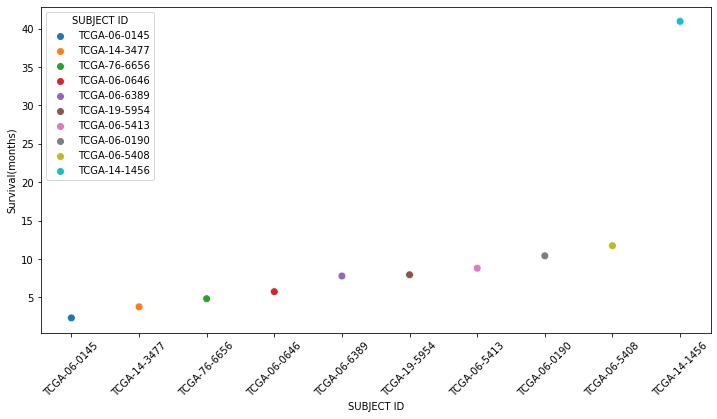

In [37]:
plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='SUBJECT ID', y='Survival(months)', hue='SUBJECT ID',
                     data=df.sort_values(by='Survival(months)'), s=60)
plt.xticks(rotation=45)
plt.show()

Here's the total tumor volume versus length of survival:

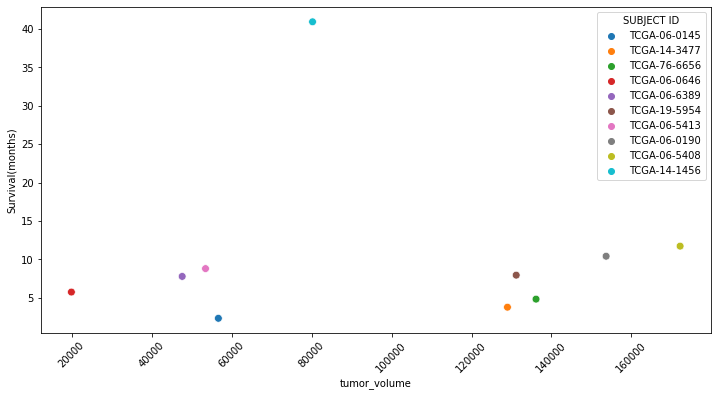

In [38]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='tumor_volume', y='Survival(months)', hue='SUBJECT ID',
                     data=df.sort_values(by='Survival(months)'), s=60)
plt.xticks(rotation=45)
plt.show()

We can bin the survival data into two: <= 5 months, > 5 months, and then study how this relates to the various radiomics features:

In [39]:
df['short_survival'] = (df['Survival(months)'] <= 5).astype(str)

In [40]:
df

,SUBJECT ID,Age,Gender,Histology,Grade,IDH-status,IDH-allele,1p/19q-co-deletion,Survival(months),Karnofsky-score,img_dir,Volume_label1,Volume_label2,Max3DDiameter_label1,Max3DDiameter_label2,flair_MeanIntensity_label1,flair_MeanIntensity_label2,flair_IntensityVariance_label1,flair_IntensityVariance_label2,flair_GrayLevelNonUniformity_label1,flair_GrayLevelNonUniformity_label2,t1_MeanIntensity_label1,t1_MeanIntensity_label2,t1_IntensityVariance_label1,t1_IntensityVariance_label2,t1_GrayLevelNonUniformity_label1,t1_GrayLevelNonUniformity_label2,t1Gd_MeanIntensity_label1,t1Gd_MeanIntensity_label2,t1Gd_IntensityVariance_label1,t1Gd_IntensityVariance_label2,t1Gd_GrayLevelNonUniformity_label1,t1Gd_GrayLevelNonUniformity_label2,t2_MeanIntensity_label1,t2_MeanIntensity_label2,t2_IntensityVariance_label1,t2_IntensityVariance_label2,t2_GrayLevelNonUniformity_label1,t2_GrayLevelNonUniformity_label2,tumor_volume,short_survival
0,TCGA-06-0145,53.0,female,glioblastoma,G4,WT,NaN,non-codel,2.3327,NaN,TCGA-06-0145,30701.67,26001.33,72.69,56.6,545.89,520.27,17906.53,38098.04,44.54,35.22,272.29,300.89,760.96,2055.93,218.97,124.33,263.96,403.47,1252.29,6356.06,195.9,68.01,369.16,374.67,4666.61,8987.5,81.17,61.59,56703.0,True
1,TCGA-06-0190,62.0,male,glioblastoma,G4,WT,NaN,non-codel,10.4150,80.0,TCGA-06-0190,128178.67,25481.33,103.42,54.99,448.48,414.06,8184.0,5077.55,306.96,64.89,219.34,231.09,525.28,313.06,987.6,264.56,202.12,446.16,942.42,11401.6,809.47,41.91,315.7,345.5,3926.52,3926.48,370.78,79.03,153660.0,False
2,TCGA-06-0646,60.0,male,glioblastoma,G4,WT,NaN,non-codel,5.7496,80.0,TCGA-06-0646,15071.0,4880.33,65.05,44.09,368.24,315.77,1062.94,2117.91,92.98,32.98,217.28,163.6,2668.47,761.87,53.54,41.08,200.47,563.07,4860.44,20406.87,44.82,8.08,290.63,306.04,2745.87,1011.14,53.24,42.82,19951.33,False
3,TCGA-06-5408,54.0,female,glioblastoma,G4,WT,NaN,non-codel,11.7292,80.0,TCGA-06-5408,121208.0,50953.0,99.32,83.09,429.72,377.25,7213.6,7954.84,252.65,101.61,241.72,257.0,732.93,690.8,833.99,375.77,228.83,404.01,1056.91,6694.63,702.04,109.29,322.21,347.75,3648.17,3265.1,367.37,158.97,172161.0,False
4,TCGA-06-5413,67.0,male,glioblastoma,G4,WT,NaN,non-codel,8.8051,60.0,TCGA-06-5413,33458.67,20032.67,77.43,48.58,328.59,257.49,844.75,1505.89,215.12,101.25,190.81,177.51,1941.83,1684.3,138.2,90.71,171.68,351.86,2121.75,11083.82,134.3,37.81,263.81,241.59,1824.67,1936.27,138.97,89.8,53491.34,False
5,TCGA-06-6389,49.0,female,glioblastoma,G4,Mutant,IDH1,non-codel,7.7866,100.0,TCGA-06-6389,25354.33,22306.0,69.08,76.58,346.28,292.98,1138.59,1413.05,138.17,127.64,200.65,144.93,1874.83,1857.54,106.84,103.79,198.6,367.52,2450.45,8321.2,100.32,43.24,245.79,255.78,1399.23,1615.57,124.78,111.48,47660.33,False
6,TCGA-14-1456,23.0,male,glioblastoma,G4,Mutant,IDH1,non-codel,40.9372,80.0,TCGA-14-1456,71234.0,9018.67,77.56,49.84,357.77,417.64,1926.22,1846.13,290.11,43.82,159.77,186.52,1073.87,797.91,442.08,61.78,172.25,261.03,1135.76,1329.63,410.27,47.19,371.85,361.03,7104.42,4443.53,202.52,30.37,80252.67,False
7,TCGA-14-3477,38.0,female,glioblastoma,G4,WT,NaN,non-codel,3.7783,80.0,TCGA-14-3477,111216.33,17771.0,91.32,57.31,386.45,391.52,2507.88,2298.95,388.33,71.04,249.66,279.76,1491.85,1173.92,498.58,93.96,212.63,353.23,1804.63,3391.7,466.75,53.29,388.8,399.23,9511.52,4840.02,201.82,60.37,128987.33,True
8,TCGA-19-5954,72.0,female,glioblastoma,G4,WT,NaN,non-codel,7.9509,60.0,TCGA-19-5954,117207.67,13970.33,111.61,64.62,374.56,333.61,2546.2,6701.7,428.01,42.3,227.96,220.0,1077.27,1979.18,652.71,76.28,208.37,385.49,1194.29,14661.05,633.9,24.3,295.79,272.45,4088.91,6104.73,321.09,37.48,131178.0,False
9,TCGA-76-6656,66.0,male,glioblastoma,G4,WT,NaN,non-codel,4.8297,60.0,TCGA-76-6656,84425.0,51710.0,101.03,68.64,372.97,308.6,2352.68,1341.83,313.03,289.2,248.07,252.06,382.22,441.93,799.78,453.17,220.71,367.79,763.65,6657.72,661.47,132.09,298.11,297.59,3025.71,2979.46,278.03,193.44,136135.0,True


Here's a plot investigating the relation between the IDH status, survival times and volume of the enhancing-non-enhancing tumor regions:

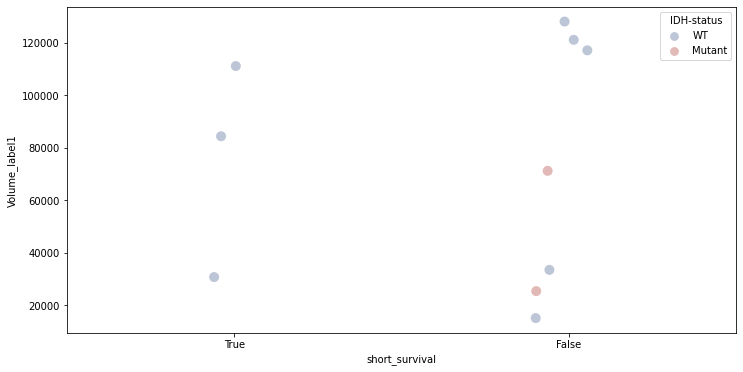

In [41]:
plt.figure(figsize=(12,6))
sns.stripplot(data=df, x="short_survival", y="Volume_label1", hue='IDH-status',palette="vlag", s=10)
plt.show()

# Integrated diagnostics

Note that multiple sources of information beyond MRI could be valuable when assessing a glioblastoma case. A system tasked with extracting relevant, actionable information should therefore have access to more than the MRI images. 

This is a general principle in medicine: important information about a patient, disease, or condition is represented in a vast set of heterogeneous data. This leads to the need for **integrated diagnostics**. 

<img width=40% src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/fusion.png">

<img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/integrated_diagnostics.png">

# What's next in the workshop?

Our sample data set is very small so we cannot say much at this point, but if you rerun this experiment using all the data available in TCGA-GBM you will have a data set that is quite large, comparably speaking. All the data is available through the TCGA database (after a simple access application process). You're therefore very close to being able to do some exciting research into brain tumors! 

## Image segmentation: the holy grail of medical image analysis

As you observed, a crucial component in the above story was the need for accurate image segmentation techniques. This gave us our _regions-of-interest_, without which we would've been unable to perform our analysis. This is a general principle in medical image analysis, and image segmentation is often called **the holy grail of medical image analysis**. 

We saw that **deep learning** gave us an approach to image segmentation. That is one reason–among many–we should take a closer look at deep learning. We turn to this next. 

# Your turn!

If you're interested in expanding the above radiomics analysis, I'm happy to discuss some possible starting points. One would f.ex. expand the data set and use a different segmentation model. And then conduct a careful statistical study of the various possible radiomic features (and also think about their their relevance).

Here are some pointers:

## Data
<a href="https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=24282668"><img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/tcia-segm.png"></a>
<br><br>
<a href="https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=1966258"><img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/tcga-gbm.png"></a>


## Model

<a href="https://github.com/rixez/brats21_kaist_mri_lab"><img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/nnunet-seg-model.png"></a>

## Deployment

<a href="https://github.com/mmiv-center/Research-Information-System/tree/master/components/Workflow-Image-AI"><img src="https://raw.githubusercontent.com/MMIV-ML/presimal2022/master/notebooks/assets/deploy.png"></a>